## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import random  
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## (Optional) Sample Visualization
You can see actual sample images and sorted class indices. Additional matplotlib package is needed.

In [2]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

alphabet = {
        'A(a)' : '0', 'B(b)' : '1', 'C(c)' : '2', 'D(d)' : '3', 'E(e)' : '4', 'F(f)' : '5', 
        'G(g)' : '6', 'H(h)' : '7', 'I(i)' : '8', 'J(j)' : '9', 'K(k)' : '10','L(l)' : '11', 
        'M(m)' : '12', 'N(n)' : '13', 'O(o)' : '14', 'P(p)' : '15', 'Q(q)' : '16', 'R(r)' : '17', 
        'S(s)' : '18', 'T(t)' : '19', 'U(u)' : '20', 'V(v)' : '21', 'W(w)' : '22', 'X(x)' : '23', 
        'Y(y)' : '24', 'Z(z)' : '25'
    }

5


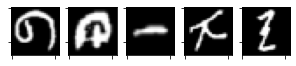

progress label:  4 6 8 10 12 14 
( E(e) G(g) I(i) K(k) M(m) O(o) )


In [3]:
# Just for reference: see actual samples

load_sample = np.load('./sample_data.npy', allow_pickle=True).item()
sample_data, sample_label = load_sample['train_data'], load_sample['train_label']
print(len(sample_data))

plt.figure(figsize=(len(sample_data),len(sample_data)))
for i in range(len(sample_data)):
    plt.subplot(1, len(sample_data), i+1)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.imshow(sample_data[i], cmap='gray')
    
plt.show()
print("progress label: ", end=' ')
label_str = '('

for i in range(len(sample_label)):
    print(int(sample_label[i]), end=' ')
    label_str += " " + list(alphabet.keys())[int(sample_label[i])]
label_str += " )"
print()
print(label_str)

In [4]:
# Use 0th GPU for training
torch.cuda.set_device(0)

In [5]:
# fix random seed to increase reproducibility
# NOTE: Do not modify here!

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# you can modify this
num_workers = 1

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [6]:
# NOTE: you can modify mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485), (0.230)),
    #transforms.RandomRotation((-90,90), interpolation=transforms.InterpolationMode.BILINEAR),
    #transforms.GaussianBlur(3, sigma=(0.1, 2.0))
])

batch_size = 256

In [7]:
# NOTE: modify path for your setting

from data_utils import Mydataset, collate_fn

train_path = './train'
valid_path = './valid'

train_ds = Mydataset(train_path, transform=transform, train=True)
valid_ds = Mydataset(valid_path, transform=transform, train=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_dl= DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

0 load from 0 to 5000
1 load from 5000 to 10000
2 load from 10000 to 15000
3 load from 15000 to 20000
4 load from 20000 to 25000
5 load from 25000 to 30000
6 load from 30000 to 35000
7 load from 35000 to 40000
8 load from 40000 to 45000
9 load from 45000 to 50000
0 load from 0 to 5000
1 load from 5000 to 10000


In [15]:
import time

train_acc = []
val_acc = []
train_loss = []

def train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, 
          load_path=None, save_path='./model.pt'):
    # Load your states
    loaded_epoch = 0
    loaded_best_acc = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_acc = state["best_acc"]
        # ...
    start_time = time.time()
    
    best_valid_accuracy = 0 if loaded_best_acc == -1 else loaded_best_acc
    
    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        n_samples = 0
        n_correct = 0
        avg_loss = 0
        model.train()
        for step, sample in enumerate(train_dl):
            img, label = sample
                       
            outputs = model((img, label))

            # img(list) : Batch x [5, 1, 28, 28]
            # x(tensor) : [batch * 5, 1, 28, 28]
            # label(tensor): [batch, 6, 26]
            # outputs(tensor): [batch, 26]
            
            model_optim.zero_grad()
            
            l = list(zip(*label))[-1]
            l = torch.Tensor(l).cuda()
            
            loss = loss_func(outputs[:,-1,:].squeeze(), l.long())
            
            loss.backward()
            model_optim.step()

            n_samples += len(label)
            for j in range(len(label)):
                n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()        
            avg_loss += loss.item()
            
            if (step + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.item(), 'accuracy:', 100 * (n_correct / n_samples))
                elapsed_time = time.time() - start_time
                print('elapsed time : %d h %d m %d s' % (elapsed_time / 3600, (elapsed_time % 3600) / 60, (elapsed_time % 60)))    
            train_acc.append(100 * n_correct / n_samples)
            train_loss.append(avg_loss / n_samples)
            
        n_samples = 0
        n_correct = 0
        model.eval()
        with torch.no_grad():
            for step, sample in enumerate(valid_dl):
                img, label = sample
                
                outputs = model(img)
                           
                n_samples += len(label)
                for j in range(len(label)):
                    n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()        
                    # print(f'{outputs[j,:].argmax(-1).item()}, {label[j,-1,:].argmax(-1)}')
            valid_accuracy = 100 * (n_correct / n_samples)
            val_acc.append(valid_accuracy)
            if valid_accuracy > best_valid_accuracy:
                state = {
                    "model": model.state_dict(),
                    "optimizer": model_optim.state_dict(),
                    "epoch": epoch + 1,
                    "best_acc": best_valid_accuracy,
                    # ...
                }
                torch.save(state, save_path)
                best_valid_accuracy = valid_accuracy
            print('Valid epoch: %d, Valid accuracy: %.2f, Best valid accuracy: %.2f' % (epoch + 1, valid_accuracy, best_valid_accuracy))

def eval(valid_dl, load_path):
    state = torch.load(load_path)
    model.load_state_dict(state["model"])
    n_samples = 0
    n_correct = 0
    model.eval()
    with torch.no_grad():
        for step, sample in enumerate(valid_dl):
            img, label = sample

            outputs = model(img)
                               
            n_samples += len(label)
            for j in range(len(label)):
                n_correct += (outputs[j].argmax(-1)[-1] == label[j][-1].cuda()).sum().item()        
                # print(f'{outputs[j,:].argmax(-1).item()}, {label[j,-1,:].argmax(-1)}')
        
    valid_accuracy = 100 * (n_correct / n_samples)
    print('Valid accuracy: %.2f' % (valid_accuracy))

In [16]:
# You can add or modify your ConvLSTM's hyperparameter (keys and values)
kwargs = {
    'cnn_input_dim': 1,
    'cnn_hidden_size': 16,
    'rnn_input_dim': 64,
    'rnn_hidden_size': 32,
    'rnn_num_layers': 1,
    'batch_size': batch_size
}

NUM_CLASSES = 26
SEQUENCE_LENGTH = 5

In [17]:
# for reload .py file without restart
import models_easy
import importlib

importlib.reload(models_easy)

from models_easy import ConvLSTM

model = ConvLSTM(sequence_length=SEQUENCE_LENGTH, num_classes=NUM_CLASSES, **kwargs).cuda()
print(model)

model_optim = optim.Adam(params=model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

ConvLSTM(
  (conv): CustomCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU(inplace=True)
    (fc): Linear(in_features=6272, out_features=64, bias=True)
  )
  (lstm): LSTM(
    (lstm): LSTM(32, 32, batch_first=True)
    (fc_in): Linear(in_features=64, out_features=32, bias=True)
    (fc_out): Linear(in_features=32, out_features=26, bias=True)
  )
)


In [18]:
print_interval = 50
max_epoch = 10

In [19]:
load_path = None
train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./model.pt')

epoch: 1 step: 50 loss: 2.7940304279327393 accuracy: 13.140625
elapsed time : 0 h 0 m 2 s
epoch: 1 step: 100 loss: 2.247584342956543 accuracy: 21.76953125
elapsed time : 0 h 0 m 5 s
epoch: 1 step: 150 loss: 1.9197139739990234 accuracy: 27.815104166666664
elapsed time : 0 h 0 m 8 s
Valid epoch: 1, Valid accuracy: 53.01, Best valid accuracy: 53.01
epoch: 2 step: 50 loss: 1.3933528661727905 accuracy: 57.40625
elapsed time : 0 h 0 m 15 s
epoch: 2 step: 100 loss: 1.185274600982666 accuracy: 61.79296875
elapsed time : 0 h 0 m 18 s
epoch: 2 step: 150 loss: 1.0021287202835083 accuracy: 65.1484375
elapsed time : 0 h 0 m 21 s
Valid epoch: 2, Valid accuracy: 77.62, Best valid accuracy: 77.62
epoch: 3 step: 50 loss: 0.7918174862861633 accuracy: 81.765625
elapsed time : 0 h 0 m 28 s
epoch: 3 step: 100 loss: 0.6522917151451111 accuracy: 83.6328125
elapsed time : 0 h 0 m 31 s
epoch: 3 step: 150 loss: 0.5590787529945374 accuracy: 85.453125
elapsed time : 0 h 0 m 33 s
Valid epoch: 3, Valid accuracy: 92

In [20]:
# load and evaluate model
load_path = './model.pt'
eval(valid_dl, load_path)

Valid accuracy: 99.50


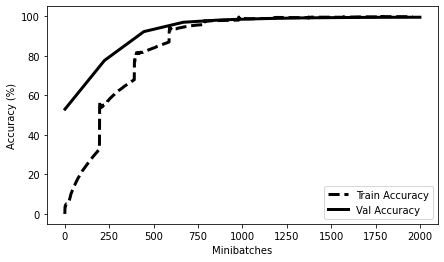

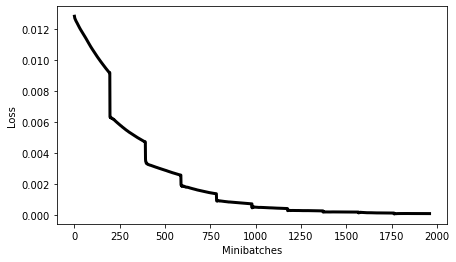

In [36]:
x = np.linspace(1,2000,10)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_acc, label='Train Accuracy', color='black', linestyle='dashed', linewidth=3)
ax.plot(x, val_acc, label='Val Accuracy', color='black', linewidth=3) 
plt.xlabel('Minibatches')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_loss, label='Train Loss', color='black', linewidth=3)
plt.xlabel('Minibatches')
plt.ylabel('Loss')
plt.show()

### Test code for grading by TA

In [ ]:
# you do not need to modify here
from data_utils import Mydataset, collate_fn

test_path = './data/emnist_progress_easy_data/test'
test_ds = Mydataset(test_path, transform=transform, train=False)
test_dl= DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [ ]:
# please change the model name to your submission model name
load_path = './model.pt'
eval(test_dl, load_path)